Task: Predict the onset of diabetes based on diagnostic measures.

**Data**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. 
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

### Imports

In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 9.0 MB/s eta 0:00:00:00:0100:01


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import mlflow.xgboost
import mlflow.sklearn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('/home/jovyan/datafabric/Full_data_sources/MLFlow/pima-indians-diabetes.csv')
display(df.head())
display(df.shape)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


(768, 9)

### Exploratory Data Analysis

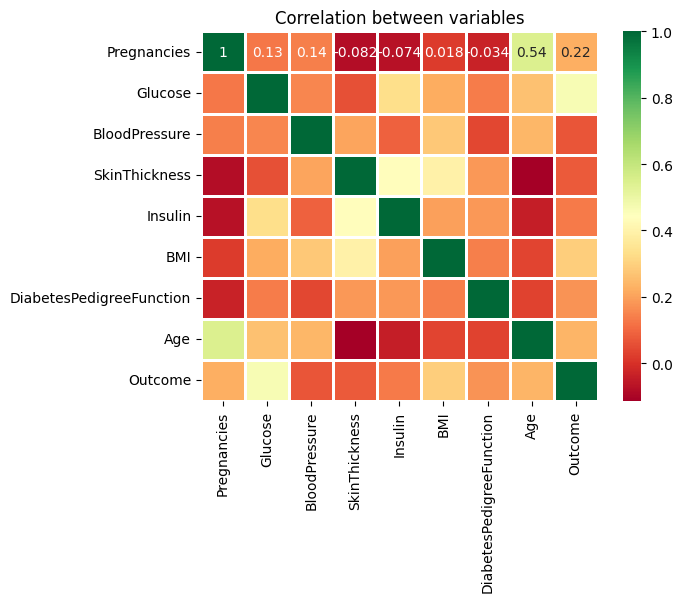

In [4]:
# Correlation
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.9);
plt.title('Correlation between variables');

In [5]:
# Missing values 
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

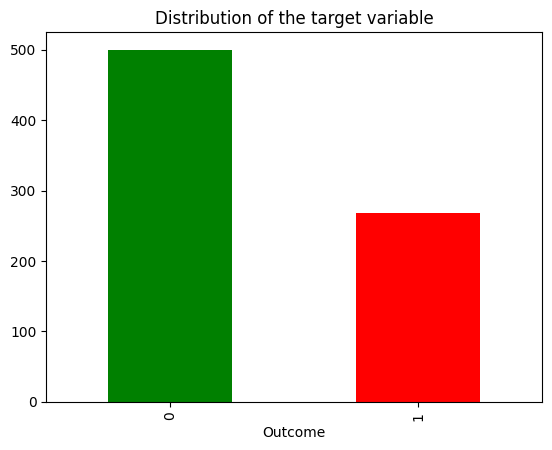

In [6]:
# Distribution of the target variable
df['Outcome'].value_counts().plot(kind='bar', color=['green', 'red']);
plt.title('Distribution of the target variable');

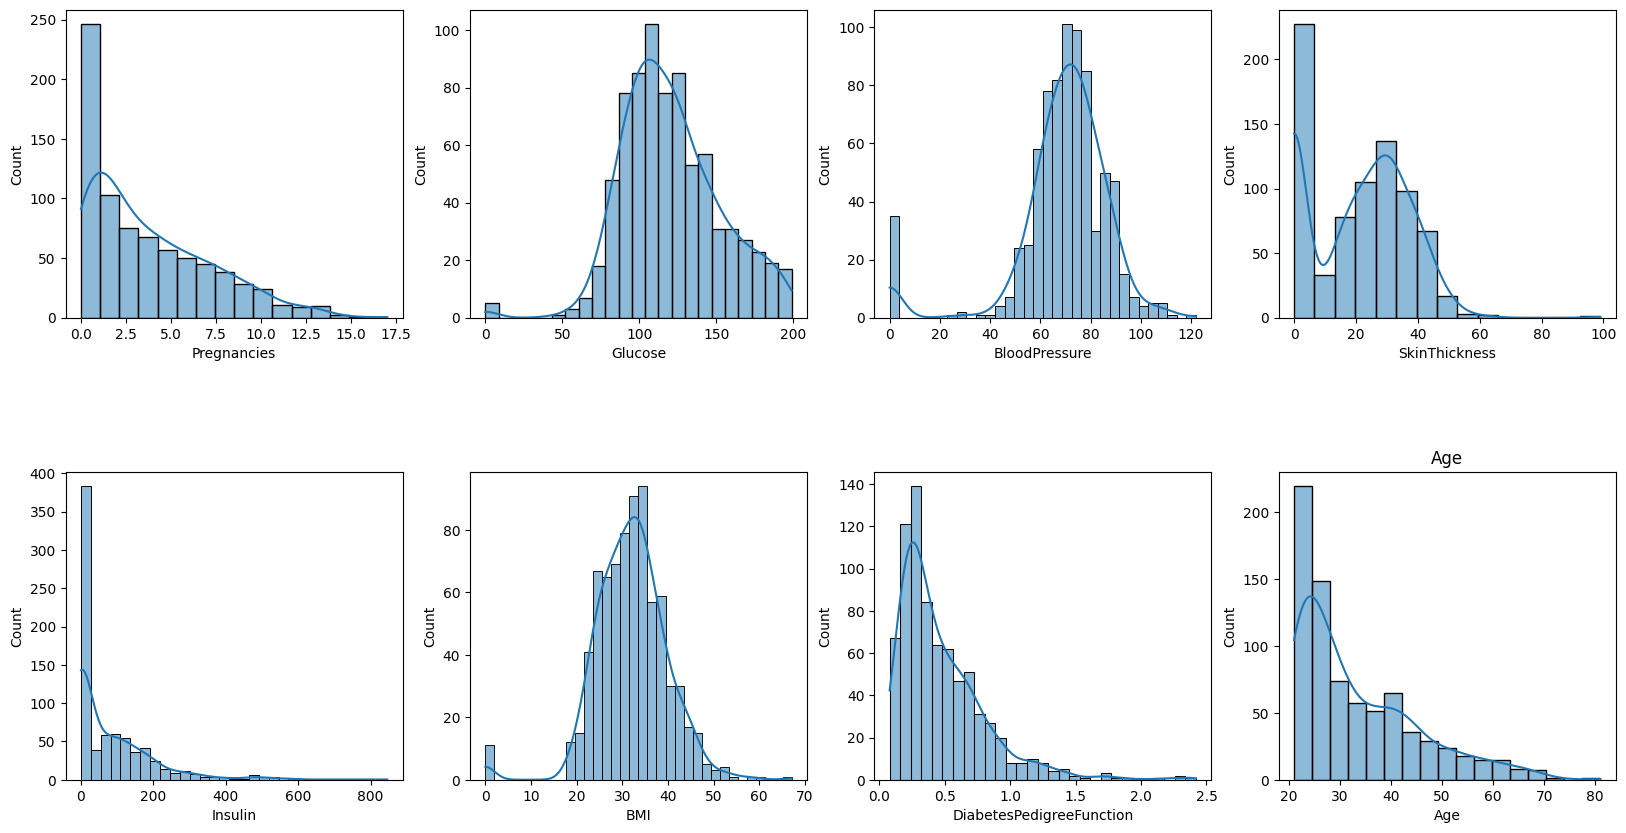

In [7]:
# Subplots of distribution of all the features

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
# Colors
sns.set_palette('RdYlGn')
for i, ax in enumerate(axes.flatten()):
    sns.histplot(df[df.columns[i]], ax=ax, kde=True, fill=True);
    plt.title(df.columns[i]);

### Train and Test split

In [8]:
X = df.iloc[:,0:8]
y = df.iloc[:,8]

In [9]:
y.head(1)

0    1
Name: Outcome, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (514, 8)
X_test shape:  (254, 8)
y_train shape:  (514,)
y_test shape:  (254,)


### Instantiating the model

In [11]:
model = XGBClassifier(eval_metric='mlogloss')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [12]:
# Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       168
           1       0.58      0.66      0.62        86

    accuracy                           0.72       254
   macro avg       0.69      0.71      0.70       254
weighted avg       0.73      0.72      0.72       254



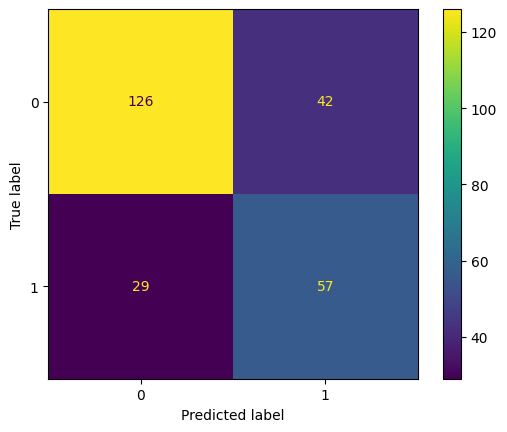

In [13]:
# Display Confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot();

### Using GridSearch with GPU for hyper-parameter optimisation

In [14]:
# Parameters for Grid Search to find the best combination
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'eval_metric': ['mlogloss', 'merror']
}

# MLFlow tracking
model_name = "first_model"
mlflow.set_experiment('Grid Search')
mlflow.sklearn.autolog(log_input_examples=True, log_model_signatures=True, 
                       log_models=True, registered_model_name=model_name)


with mlflow.start_run() as run:
    xgb = XGBClassifier(device='cuda', verbosity=2)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
mlflow.end_run()

2024/01/15 16:30:38 INFO mlflow.tracking.fluent: Experiment with name 'Grid Search' does not exist. Creating a new experiment.
2024/01/15 16:30:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/01/15 16:30:39 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
           ...`
2024/01/15 16:30:39 WARNING m

In [15]:
print("Best parameters found: ", grid_search.best_params_)
print("Classification report with best parameters: ", classification_report(y_test, grid_search.predict(X_test)))

2024/01/15 16:31:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Best parameters found:  {'eval_metric': 'mlogloss', 'learning_rate': 0.01, 'max_depth': 3}
Classification report with best parameters:                precision    recall  f1-score   support

           0       0.73      0.93      0.81       168
           1       0.69      0.31      0.43        86

    accuracy                           0.72       254
   macro avg       0.71      0.62      0.62       254
weighted avg       0.71      0.72      0.69       254



#### Loading the best parameters model

In [16]:
model = mlflow.pyfunc.load_model(model_uri=f"models:/first_model/1")

# Get sample for testing the loaded model
sample = X_test.sample(5)
sample

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
10,4,110,92,0,0,37.6,0.191,30
299,8,112,72,0,0,23.6,0.840,58
557,8,110,76,0,0,27.8,0.237,58
357,13,129,0,30,0,39.9,0.569,44
56,7,187,68,39,304,37.7,0.254,41


In [17]:
print("Model prediction: ", model.predict(sample))
print("Actual values: \n", y_test[sample.index])

Model prediction:  [0 0 0 0 1]
Actual values: 
 10     0
299    0
557    0
357    1
56     1
Name: Outcome, dtype: int64
